In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-04-02 23:11:54--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.177.16, 52.217.170.16, 16.15.178.206, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.177.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.96MB/s    in 2.2s    

2025-04-02 23:11:57 (5.96 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Downloads and uncompresses the data

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
 data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Gives us a look at the data

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
 values = [float(x) for x in line.split(",")[1:]]
 temperature[i] = values[1]
 raw_data[i, :] = values[:]

parces the data

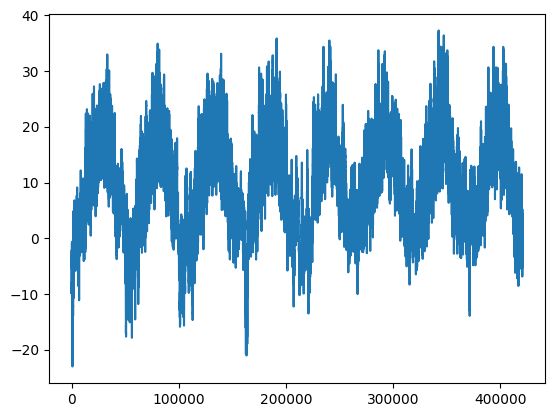

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

Plot of temp in degrees of celsius evey 10 min for about 2009 to 2016

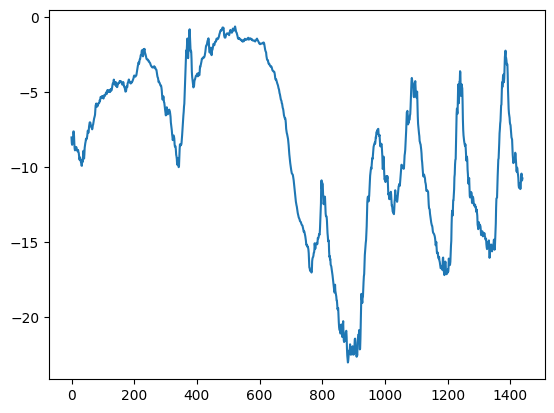

In [5]:
plt.plot(range(1440), temperature[:1440])

Plot of the first 10 days of temps

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)
num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
  data=int_sequence[:-3],
  targets=int_sequence[3:],
  sequence_length=3,
  batch_size=2,
)
for inputs, targets in dummy_dataset:
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))


[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Formats our data correctally

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=0,
 end_index=num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples,
 end_index=num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples + num_val_samples)

Creats the data sets for training, validation, and testing

In [10]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


gives info on train_dataset

In [11]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

adds in needed libaries

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 72.2491 - mae: 6.5113 - val_loss: 12.9089 - val_mae: 2.6985
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 11.6038 - mae: 2.6361 - val_loss: 9.3496 - val_mae: 2.3770
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 9.9581 - mae: 2.4698 - val_loss: 9.5271 - val_mae: 2.3856
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 9.5336 - mae: 2.4123 - val_loss: 9.3115 - val_mae: 2.3603
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 9.2534 - mae: 2.3706 - val_loss: 9.7480 - val_mae: 2.3941
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 9.0633 - mae: 2.3415 - val_loss: 9.8452 - val_mae: 2.4038
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 8.9062 - mae: 2.3217 - val_loss: 9.7225 - val_mae: 2.3930
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 8.7689 - mae: 2.3035 - val_loss: 9.8627 - val_mae: 2.4161
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━

In [ ]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 10.2653 - mae: 2.5148
Test MAE: 2.51


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 16)                  │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,108 (12.14 KB)

 Trainable params: 1,553 (6.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,555 (6.08 KB)

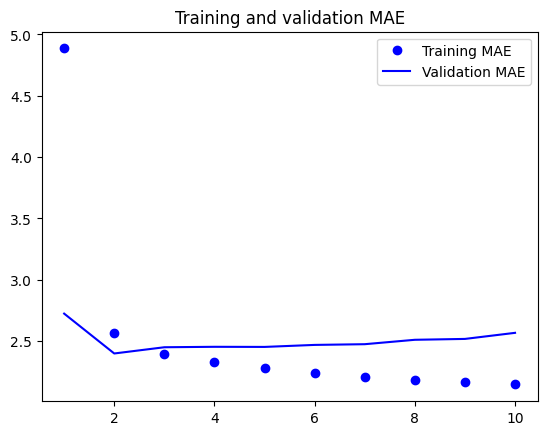

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Above is the GRU Model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 77.7423 - mae: 6.7397 - val_loss: 13.0428 - val_mae: 2.7250
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 11.9619 - mae: 2.6711 - val_loss: 9.6157 - val_mae: 2.4002
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 9.7558 - mae: 2.4341 - val_loss: 9.8828 - val_mae: 2.4510
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 9.1526 - mae: 2.3518 - val_loss: 9.9287 - val_mae: 2.4546
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 8.7312 - mae: 2.2994 - val_loss: 9.9439 - val_mae: 2.4537
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 8.4213 - mae: 2.2570 - val_loss: 10.0775 - val_mae: 2.4700
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 8.1778 - mae: 2.2251 - val_loss: 10.1289 - val_mae: 2.4758
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 7.9942 - mae: 2.2016 - val_loss: 10.3493 - val_mae: 2.5117
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━

In [ ]:

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 10.8621 - mae: 2.5866
Test MAE: 2.59


Runs the model and gives the Test MAE

In [ ]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 16)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,004 (15.64 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,003 (7.83 KB)

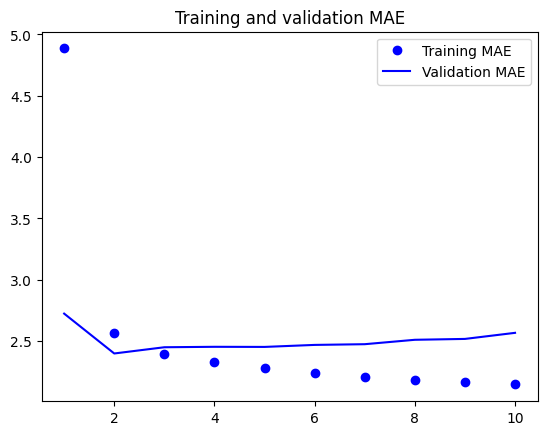

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Above is the LSTM Model

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, return_sequences=True)(inputs)
x = layers.GRU(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 58.8304 - mae: 5.7006 - val_loss: 11.2071 - val_mae: 2.5445
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 10.8348 - mae: 2.5483 - val_loss: 9.1895 - val_mae: 2.3527
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 9.5381 - mae: 2.4102 - val_loss: 8.8599 - val_mae: 2.3127
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 8.9920 - mae: 2.3464 - val_loss: 9.0837 - val_mae: 2.3399
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 8.6919 - mae: 2.3064 - val_loss: 9.0417 - val_mae: 2.3402
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 8.4253 - mae: 2.2729 - val_loss: 9.1480 - val_mae: 2.3530
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 8.1626 - mae: 2.2363 - val_loss: 10.5617 - val_mae: 2.5278
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 7.9050 - mae: 2.2010 - val_loss: 9.7150 - val_mae: 2.4211
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━

In [23]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 10.0437 - mae: 2.4718
Test MAE: 2.46


In [24]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_12 (GRU)                         │ (None, 120, 16)             │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_13 (GRU)                         │ (None, 16)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,372 (24.89 KB)

 Trainable params: 3,185 (12.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,187 (12.45 KB)

Above is GRU model with 1 stacked layer

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, return_sequences=True)(inputs)
x = layers.GRU(16, return_sequences=True)(x)
x = layers.GRU(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 70.0637 - mae: 6.2954 - val_loss: 12.6398 - val_mae: 2.6489
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 11.3659 - mae: 2.5914 - val_loss: 9.3894 - val_mae: 2.3783
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 9.1552 - mae: 2.3623 - val_loss: 9.4322 - val_mae: 2.3907
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 8.5025 - mae: 2.2852 - val_loss: 10.0382 - val_mae: 2.4648
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 8.0634 - mae: 2.2306 - val_loss: 9.6202 - val_mae: 2.4073
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.6201 - mae: 2.1703 - val_loss: 9.8710 - val_mae: 2.4351
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 7.2119 - mae: 2.1141 - val_loss: 10.1365 - val_mae: 2.4885
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 6.8319 - mae: 2.0566 - val_loss: 11.7009 - val_mae: 2.6370
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━

In [27]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 10.3321 - mae: 2.5103
Test MAE: 2.51


In [28]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_17 (GRU)                         │ (None, 120, 16)             │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_18 (GRU)                         │ (None, 120, 16)             │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_19 (GRU)                         │ (None, 16)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,636 (37.64 KB)

 Trainable params: 4,817 (18.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,819 (18.83 KB)

Above is GRU model with 2 stacked layers

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 63.8058 - mae: 6.0307 - val_loss: 11.9788 - val_mae: 2.6213
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 10.8823 - mae: 2.5446 - val_loss: 9.6862 - val_mae: 2.3963
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 8.8498 - mae: 2.3214 - val_loss: 10.1716 - val_mae: 2.4727
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 8.1106 - mae: 2.2263 - val_loss: 10.4107 - val_mae: 2.4844
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 7.5745 - mae: 2.1533 - val_loss: 10.5972 - val_mae: 2.5221
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 7.1582 - mae: 2.0923 - val_loss: 11.0391 - val_mae: 2.5675
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 6.8016 - mae: 2.0381 - val_loss: 11.3019 - val_mae: 2.6075
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 6.5084 - mae: 1.9909 - val_loss: 11.1983 - val_mae: 2.6025
Epoch 9/10
819/819 ━━━━━━━━━━━━

In [30]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 11.4995 - mae: 2.6523
Test MAE: 2.64


In [31]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 120, 16)             │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,228 (32.14 KB)

 Trainable params: 4,113 (16.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,115 (16.08 KB)

Above is LSTM model with 1 stacked layer

In [32]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16, return_sequences=True) (x)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 62.7657 - mae: 5.9803 - val_loss: 12.7284 - val_mae: 2.7285
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 11.2927 - mae: 2.6064 - val_loss: 10.5919 - val_mae: 2.5449
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 8.9746 - mae: 2.3357 - val_loss: 10.3514 - val_mae: 2.5093
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 8.1770 - mae: 2.2241 - val_loss: 10.5658 - val_mae: 2.5368
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.5608 - mae: 2.1402 - val_loss: 10.7624 - val_mae: 2.5615
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.1111 - mae: 2.0773 - val_loss: 11.2701 - val_mae: 2.6078
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 6.7299 - mae: 2.0179 - val_loss: 11.6822 - val_mae: 2.6568
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 6.4466 - mae: 1.9719 - val_loss: 12.1370 - val_mae: 2.7238
Epoch 9/10
819/819 ━━━━━━━━━━━

In [33]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 11.2372 - mae: 2.6434
Test MAE: 2.64


In [34]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 120, 16)             │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120, 16)             │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,452 (48.64 KB)

 Trainable params: 6,225 (24.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,227 (24.33 KB)

Above is LSTM model with 2 stacked layers

In [12]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
 save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=50,
 validation_data=val_dataset,
 callbacks=callbacks)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 202s 243ms/step - loss: 77.9703 - mae: 6.8352 - val_loss: 13.4387 - val_mae: 2.7639
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 197s 241ms/step - loss: 20.8696 - mae: 3.5048 - val_loss: 9.9178 - val_mae: 2.4426
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 198s 242ms/step - loss: 18.3804 - mae: 3.3004 - val_loss: 9.3912 - val_mae: 2.3910
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 198s 242ms/step - loss: 17.6944 - mae: 3.2371 - val_loss: 9.3964 - val_mae: 2.3851
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 198s 242ms/step - loss: 16.9035 - mae: 3.1682 - val_loss: 9.2839 - val_mae: 2.3711
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 198s 241ms/step - loss: 16.6098 - mae: 3.1353 - val_loss: 9.2819 - val_mae: 2.3722
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 197s 241ms/step - loss: 16.0208 - mae: 3.0912 - val_loss: 9.1556 - val_mae: 2.3584
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 198s 242ms/step - loss: 15.8696 - mae: 3.0702 - val_loss: 9.3246 - val_mae: 2.3763
Epoch 9/50
819/

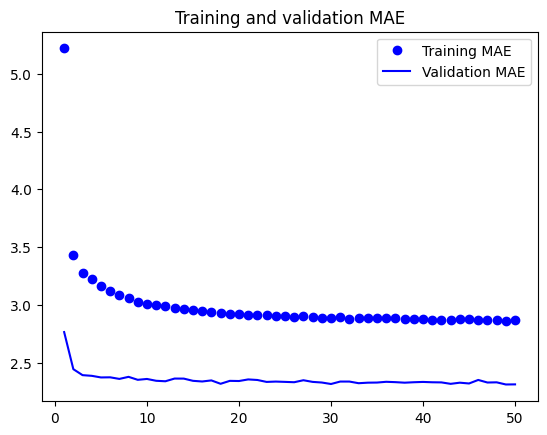

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [14]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - loss: 10.3351 - mae: 2.5159
Test MAE: 2.52


In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,004 (15.64 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,003 (7.83 KB)

Above is LSTM model with dropout

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(128, return_sequences=True)(inputs)
x = layers.GRU(128)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 16.7442 - mae: 2.9902 - val_loss: 8.9043 - val_mae: 2.3361
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 6.3726 - mae: 1.9734 - val_loss: 11.5826 - val_mae: 2.6398
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 3.1241 - mae: 1.3726 - val_loss: 12.5850 - val_mae: 2.7559
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 1.7452 - mae: 1.0200 - val_loss: 12.9038 - val_mae: 2.7960
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 1.1406 - mae: 0.8206 - val_loss: 13.1915 - val_mae: 2.8300
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8454 - mae: 0.7050 - val_loss: 12.7393 - val_mae: 2.7814
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.6762 - mae: 0.6279 - val_loss: 12.7660 - val_mae: 2.7802
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.5761 - mae: 0.5776 - val_loss: 12.2068 - val_mae: 2.7154
Epoch 9/10
819/819 ━━━━━━━━━━━━━

In [18]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 9.9154 - mae: 2.4980
Test MAE: 2.49


In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 120, 128)            │          55,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 308,996 (1.18 MB)

 Trainable params: 154,497 (603.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 154,499 (603.52 KB)

Above is GRU model with 1 stacked layer with a 128 hidden layer

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(8, return_sequences=True)(inputs)
x = layers.GRU(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 84.4070 - mae: 7.1621 - val_loss: 28.4343 - val_mae: 3.9051
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 21.6210 - mae: 3.4122 - val_loss: 11.7325 - val_mae: 2.5869
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 11.1765 - mae: 2.5837 - val_loss: 9.5218 - val_mae: 2.3755
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 10.1010 - mae: 2.4787 - val_loss: 9.3129 - val_mae: 2.3594
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 9.8305 - mae: 2.4459 - val_loss: 9.0163 - val_mae: 2.3253
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 9.5868 - mae: 2.4166 - val_loss: 9.2160 - val_mae: 2.3539
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 9.3720 - mae: 2.3921 - val_loss: 9.0044 - val_mae: 2.3266
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 9.2123 - mae: 2.3731 - val_loss: 9.0772 - val_mae: 2.3312
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━

In [31]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 10.2483 - mae: 2.4981
Test MAE: 2.50


Above is GRU model with 1 stacked layer with a 8 hidden layer

In [34]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 35.9751 - mae: 4.3327 - val_loss: 9.2410 - val_mae: 2.3567
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 9.0947 - mae: 2.3521 - val_loss: 9.4908 - val_mae: 2.3802
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 8.0200 - mae: 2.2122 - val_loss: 9.6665 - val_mae: 2.3996
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 7.1774 - mae: 2.0984 - val_loss: 9.9647 - val_mae: 2.4469
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 6.3996 - mae: 1.9835 - val_loss: 11.3700 - val_mae: 2.6158
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 5.7166 - mae: 1.8766 - val_loss: 11.5529 - val_mae: 2.6431
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 5.0767 - mae: 1.7688 - val_loss: 11.6847 - val_mae: 2.6752
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 4.5399 - mae: 1.6681 - val_loss: 12.7149 - val_mae: 2.7728
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━

In [35]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 10.3456 - mae: 2.5120
Test MAE: 2.51


Above is GRU model with 1 stacked layer with a 32 hidden layer

In [40]:
x = layers.GRU(16, return_sequences=True)(inputs)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_conv.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 33.1241 - mae: 4.4131 - val_loss: 20.0104 - val_mae: 3.5002
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 19.1882 - mae: 3.4720 - val_loss: 19.6904 - val_mae: 3.4645
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 16.7631 - mae: 3.2438 - val_loss: 24.2522 - val_mae: 3.8626
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 15.1102 - mae: 3.0760 - val_loss: 20.8327 - val_mae: 3.5405
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 13.9832 - mae: 2.9520 - val_loss: 21.9547 - val_mae: 3.6597
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 13.1094 - mae: 2.8550 - val_loss: 21.3903 - val_mae: 3.5766
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 12.3195 - mae: 2.7674 - val_loss: 21.9234 - val_mae: 3.6081
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 11.6057 - mae: 2.6857 - val_loss: 21.1716 - val_mae: 3.5949
Epoch 9/10
819/819 ━━━━━

In [41]:
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 21.5825 - mae: 3.6757
Test MAE: 3.67


In [42]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_21 (GRU)                         │ (None, 120, 16)             │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 109, 8)              │           1,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 54, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 49, 8)               │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,964 (27.21 KB)

 Trainable params: 3,481 (13.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,483 (13.61 KB)

In [45]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
 save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 183s 220ms/step - loss: 70.8504 - mae: 6.5448 - val_loss: 12.6731 - val_mae: 2.6655
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 180s 220ms/step - loss: 19.6431 - mae: 3.3917 - val_loss: 9.7946 - val_mae: 2.4137
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 180s 220ms/step - loss: 17.7846 - mae: 3.2409 - val_loss: 9.4263 - val_mae: 2.3810
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 180s 219ms/step - loss: 16.9213 - mae: 3.1691 - val_loss: 9.1844 - val_mae: 2.3554
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 179s 219ms/step - loss: 16.4207 - mae: 3.1223 - val_loss: 9.0126 - val_mae: 2.3343
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 181s 221ms/step - loss: 15.8170 - mae: 3.0643 - val_loss: 8.8753 - val_mae: 2.3181
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 179s 218ms/step - loss: 15.5266 - mae: 3.0430 - val_loss: 9.1971 - val_mae: 2.3627
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 179s 219ms/step - loss: 15.1372 - mae: 3.0063 - val_loss: 8.8832 - val_mae: 2.3187
Epoch 9/10
819/

In [46]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - loss: 10.1945 - mae: 2.4950
Test MAE: 2.49
